<a href="https://colab.research.google.com/github/SaifEleslamElgalaly/food-101-classification/blob/main/Image%20Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and Preprocessing Dataset

In [1]:
# Mount Google Drive and copy dataset if needed
from google.colab import drive
import os, shutil, stat, collections
from collections import defaultdict

In [5]:
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/food-101" "/content/"
data_path = "/content/food-101"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 1) استيراد المكتبات
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [7]:
# 3) تجهيز التوازي (multiprocessing)
num_processes = 6
pool = mp.Pool(processes=num_processes)

In [8]:
# 4) بناء خريطة الكلاسات
class_to_ix, ix_to_class = {}, {}
with open(os.path.join(data_path, 'meta', 'classes.txt'), 'r') as f:
    classes = [l.strip() for l in f]
    class_to_ix = {c:i for i,c in enumerate(classes)}
    ix_to_class = {i:c for i,c in enumerate(classes)}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))


In [9]:
# 5) تقسيم الصور إلى مجلدات train / test (مرة واحدة)
def generate_dir_file_map(path_txt):
    d = defaultdict(list)
    with open(path_txt) as f:
        for line in f:
            dir_name, fname = line.strip().split('/')
            d[dir_name].append(fname + '.jpg')
    return d

train_map = generate_dir_file_map(os.path.join(data_path, 'meta', 'train.txt'))
test_map  = generate_dir_file_map(os.path.join(data_path, 'meta', 'test.txt'))

def copytree(src, dst, ignore_map):
    if not os.path.exists(dst):
        os.makedirs(dst)
    for class_name in os.listdir(src):
        sdir = os.path.join(src, class_name)
        ddir = os.path.join(dst, class_name)
        os.makedirs(ddir, exist_ok=True)
        for img_name in os.listdir(sdir):
            keep = img_name in ignore_map[class_name]
            if keep:
                shutil.copy(os.path.join(sdir, img_name), os.path.join(ddir, img_name))

if not os.path.isdir(os.path.join(data_path, 'train')):
    copytree(os.path.join(data_path, 'images'), os.path.join(data_path, 'train'), train_map)
if not os.path.isdir(os.path.join(data_path, 'test')):
    copytree(os.path.join(data_path, 'images'), os.path.join(data_path, 'test'), test_map)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation للـ Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test ما نعمللهمش Augmentation بس نعمل Rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# توليد الداتا أثناء التدريب
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Visualization Tools

In [11]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.2 MB/s eta 0:00:00


In [12]:
import random
from PIL import Image
from ipywidgets import interact # Import interact from ipywidgets



@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    class_name = ix_to_class[n_class]
    folder_path = os.path.join(data_path, 'train', class_name)  # للتدريب

    all_images = os.listdir(folder_path)
    chosen_images = random.sample(all_images, min(len(all_images), 32))

    nrows, ncols = 4, 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(chosen_images):
            img_path = os.path.join(folder_path, chosen_images[i])
            img = Image.open(img_path)
            ax.imshow(img)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

In [13]:
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    class_name = ix_to_class[n_class]
    folder_path = os.path.join(data_path, 'test', class_name)

    all_images = os.listdir(folder_path)
    chosen_images = random.sample(all_images, min(len(all_images), 32))

    nrows, ncols = 4, 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(f"Class: {class_name}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(chosen_images):
            img_path = os.path.join(folder_path, chosen_images[i])
            img = Image.open(img_path)
            ax.imshow(img)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

Image Augmentation

In [14]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# عدد الكلاسات
n_classes = len(sorted_class_to_ix)

# إعداد الـ train_datagen مع Augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# إعداد الـ validation/test datagen (بدون augmentations)
test_datagen = ImageDataGenerator(rescale=1./255)

# إعداد الـ Generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


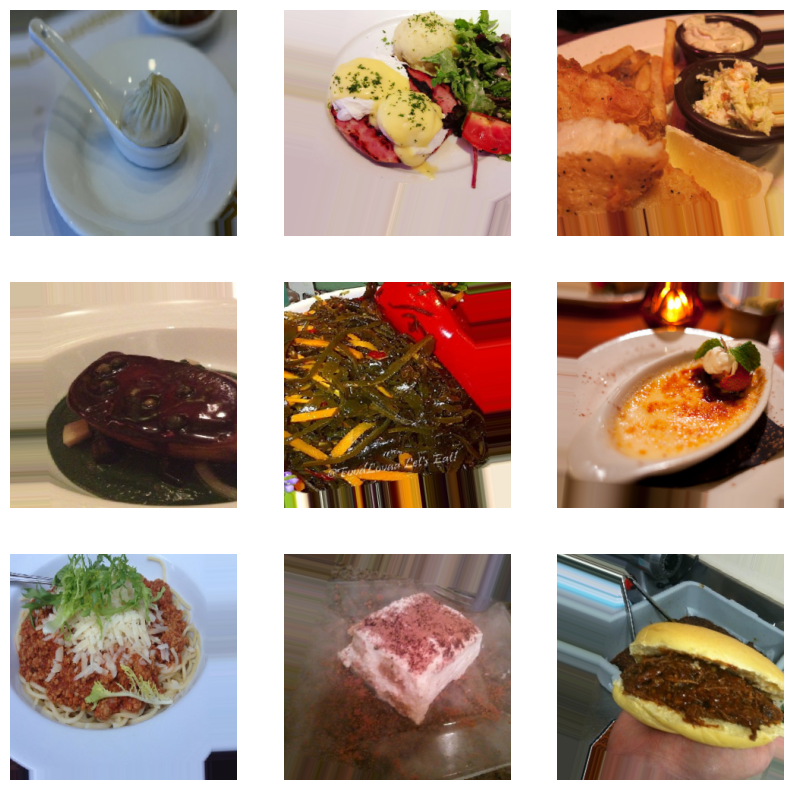

In [15]:
# عرض صور من الـ train_generator مع Augmentation
def plot_augmented_images(generator):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()

plot_augmented_images(train_generator)
